# Modélisation 

### Import des modules 

In [1]:
import pandas as pd
import numpy as np
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

Prérequis 

S'être familiarisé avec le jeu de données via l'analyse exploratoire.
Avoir compris ce qu'est le feature engineering en regardant les chapitres indiqués en ressources. 
Résultat attendu  

Le notebook template avec la partie "Feature Engineering” complétée.
Recommandations  

Nous vous déconseillons fortement d'utiliser des outils comme ChatGPT pour cette section. D'abord, parce que des erreurs se glissent dans les codes générés en feature engineering souvent d'une manière assez subtile et qu’en tant que débutants, vous ne les  détecterez pas. Par contre, l'évaluateur pourra les voir. Ensuite, car cette compétence ne s'apprend pas autrement que par la pratique, ce n'est donc pas dans votre intérêt de l'automatiser à ce stade de votre apprentissage. 

Si le code de l’analyse exploratoire est long, ne pas hésiter à créer un second notebook pour l’alléger.  
Essayer de couvrir, dans la création des features, plusieurs catégories d'informations du jeu de données (localisation, temporalité, structure du bâtiment, etc.)
Voici quelques pistes de réflexion pour le feature engineering:
Il peut être intéressant d'indiquer à un modèle si un bâtiment a plusieurs types d'usages via des features binaires ou des proportions.
Pour certaines features catégorielles à haute cardinalité, il peut être intéressant de créer des tranches de valeurs pour les compresser.
Les valeurs des sources d'énergies (gaz, électricité) ne peuvent pas être utilisées, car cela créerait du data leakage, mais rien ne nous empêche de créer des features indiquant quels types de sources d'énergie existent au sein de chaque bâtiment (ce sont des informations structurelles des bâtiments, indépendantes de l'intensité de la consommation en énergie).
Points de vigilance  

Attention au data leakage : on ne peut pas donner à un modèle de ML des features qui ne peuvent être calculées qu'en connaissant la consommation d'énergie, alors que c'est cette quantité qu'il faut prédire.
Se fixer à l'avance un certain nombre d'heures à ne pas dépasser sur cette partie. En effet, on pourrait infiniment réfléchir à rajouter de plus en plus de features avant de réaliser un 1er modèle. L’objectif ici est surtout de comprendre par la pratique l’importance du feature engineering. Vous ne serez pas jugé sur la performance de votre modèle sur ce projet.
Ressources 

La section Feature Engineering du chapitre Transformez les variables pour faciliter l'apprentissage du modèle du cours d'initiation.
La section Feature Engineering de ce cours avancé qui couvre quelques techniques classiques et le data leakage.

Crée une copie propre du jeu de données pour les prochaines étapes.

Assainit le typage des colonnes numériques (conversion explicite).

Prépare le DataFrame pour des opérations mathématiques, statistiques ou de machine learning sans erreurs de type.

In [2]:
[col for col in df_model.columns]

NameError: name 'df_model' is not defined

In [3]:
# Point de départ : on repart d'une copie de df (sortie EDA)
df_model = pd.read_csv("C:\\Users\\matde\\Documents\\OpenClassrooms\\Projet_6\\df_model.csv")
df_fe = df_model.copy()

# Sécurisation du typage numérique pour éviter surprises plus tard
to_num = [
    "PropertyGFATotal",
    "PropertyGFABuilding(s)",
    "PropertyGFAParking",
    "NumberofBuildings",
    "NumberofFloors",
    "Latitude",
    "Longitude",
    "LargestPropertyUseTypeGFA"
]

for c in to_num:
    if c in df_fe.columns:
        df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce")

print("df_fe shape:", df_fe.shape)

df_fe shape: (1538, 14)


On met en place une variable présence de parking binaire : 

In [4]:
    # Flag binaire : présence de parking
    df_fe["HasParking"] = (df_fe["PropertyGFAParking"] > 0).astype(int)
    print("df_fe shape:", df_fe.shape)

df_fe shape: (1538, 15)


Calcule l’âge du bâtiment à partir de l’année des données (DataYear) et de l’année de construction (YearBuilt).  
Intérêt :

Variable temporelle souvent très explicative (vieux bâtiments = moins efficaces énergétiquement, p. ex.).

Permet de comparer des bâtiments de différentes générations.

In [5]:
if {"YearBuilt"}.issubset(df_fe.columns):
    df_fe["BuildingAge"] = 2016 - df_fe["YearBuilt"]
print("df_fe shape:", df_fe.shape)

df_fe shape: (1538, 16)


Calcule la proportion de surface dédiée au parking par rapport à la surface totale (GFA = Gross Floor Area).  
Avant cela, on évite les divisions par zéro en remplaçant les valeurs ≤ 0 par NaN.  
Intérêt :

Donne une idée de la typologie du site (bureaux urbains ≠ centres commerciaux avec grands parkings).

Peut être utile pour estimer la consommation énergétique (parking chauffé, ventilé, etc.).

In [6]:
if {"PropertyGFAParking","PropertyGFATotal"}.issubset(df_fe.columns):
    df_fe.loc[df_fe["PropertyGFATotal"] <= 0, "PropertyGFATotal"] = np.nan
    df_fe["ParkingRatio"] = df_fe["PropertyGFAParking"] / df_fe["PropertyGFATotal"]
print("df_fe shape:", df_fe.shape)

df_fe shape: (1538, 17)


Surface moyenne par étage
Calcule la surface moyenne d’un étage.  
Intérêt :

Donne une idée de la compacité verticale.

Utile pour repérer des erreurs de saisie (par ex. 1 étage pour 50 000 m² → suspect).

In [7]:
if {"PropertyGFABuilding(s)","NumberofFloors"}.issubset(df_fe.columns):
    floors = df_fe["NumberofFloors"].replace(0, np.nan)
    df_fe["AreaPerFloor"] = df_fe["PropertyGFABuilding(s)"] / floors
print("df_fe shape:", df_fe.shape)

df_fe shape: (1538, 18)


Densité de bâtiments  
Calcule le nombre de bâtiments par unité de surface totale.
ntérêt :

Reflète la fragmentation du site (plusieurs petits bâtiments vs un grand).

Peut influencer la logistique, les coûts, la consommation énergétique, etc.

In [8]:
[col for col in df_model.columns]

['PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'NumberofBuildings',
 'NumberofFloors',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'SiteEnergyUse(kBtu)']

In [9]:
if {"NumberofBuildings","PropertyGFATotal"}.issubset(df_fe.columns):
    df_fe["BuildingDensity"] = df_fe["NumberofBuildings"] / df_fe["PropertyGFATotal"]
print("df_fe shape:", df_fe.shape)

df_fe shape: (1538, 19)


Clustering spatial avec K-Means  
K-Means regroupe les points (ici les bâtiments) en k zones géographiques homogènes, en fonction de leur proximité en latitude/longitude.  
Plus réaliste : regroupe les bâtiments où ils se trouvent réellement.

Flexible : on choisit n_clusters selon ton échantillon (par ex. 5, 10, 20).

Reproductible : les mêmes clusters reviennent avec le même random_state.

In [10]:
from sklearn.cluster import KMeans

if {"Latitude", "Longitude"}.issubset(df_fe.columns):
    coords = df_fe[["Latitude", "Longitude"]].dropna()
    kmeans = KMeans(n_clusters=10, random_state=42)
    clusters = kmeans.fit_predict(coords)
    df_fe.loc[coords.index, "GeoCluster"] = clusters

C:\Users\matde\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\matde\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\matde\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\matde\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^

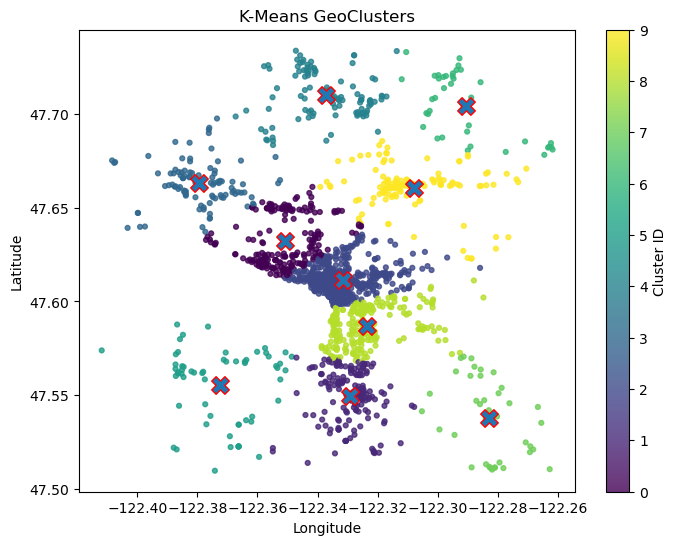

In [11]:
import numpy as np
import matplotlib.pyplot as plt

assert {"Latitude","Longitude","GeoCluster"}.issubset(df_fe.columns)

# Nuage de points coloré par cluster
plt.figure(figsize=(8,6))
sc = plt.scatter(
    df_fe["Longitude"], df_fe["Latitude"],
    c=df_fe["GeoCluster"], s=12, alpha=0.8
)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("K-Means GeoClusters")
plt.colorbar(sc, label="Cluster ID")

# Centroides si tu as l'objet kmeans (optionnel)
try:
    centers = kmeans.cluster_centers_   # shape: (k, 2) -> [lat, lon]
    plt.scatter(centers[:,1], centers[:,0], marker="X", s=160, edgecolor="r")
except Exception:
    pass

plt.show()


Encodages légers & préparation des colonnes

In [12]:
# ===== Encodages légers =====

# Catégories principales : remplir les NA par une modalité explicite
if "EPAPropertyType" in df_fe.columns:
    df_fe["EPAPropertyType"] = df_fe["EPAPropertyType"].fillna("Unknown")

if "LargestPropertyUseType" in df_fe.columns:
    df_fe["LargestPropertyUseType"] = df_fe["LargestPropertyUseType"].fillna("Unknown")

# Prévisualisation rapide des nouvelles colonnes
created_cols = ["BuildingAge","ParkingRatio","AreaPerFloor","BuildingDensity",
                "LatBin","LonBin","GeoCluster","HasParking"]
created_cols = [c for c in created_cols if c in df_fe.columns]
print("Nouvelles features créées:", created_cols)
display(df_fe[created_cols].head())


Nouvelles features créées: ['BuildingAge', 'ParkingRatio', 'AreaPerFloor', 'BuildingDensity', 'GeoCluster', 'HasParking']


,BuildingAge,ParkingRatio,AreaPerFloor,BuildingDensity,GeoCluster,HasParking
0,89,0.000000,7369.500000,0.000011,2.0,0
1,20,0.145453,8045.636364,0.000010,2.0,1
2,47,0.874829,4782.225610,0.000004,2.0,1
3,90,0.000000,6132.000000,0.000016,2.0,0
4,36,0.353115,6310.000000,0.000006,2.0,1


définit proprement le jeu de features pour la modélisation tout en évitant le data leakage.

### Synthèse — Feature Engineering

Le feature engineering a permis d’enrichir les données brutes avec des variables dérivées pertinentes pour modéliser la consommation énergétique des bâtiments.
Les nouvelles caractéristiques ajoutées sont les suivantes :

#### 1. Caractéristiques structurelles

**BuildingAge** : âge du bâtiment calculé comme 2016 - YearBuilt.
Cette variable capte les effets d’obsolescence énergétique ou de rénovations plus récentes.

**AreaPerFloor** : surface moyenne par étage (GFA / NumberOfFloors).
Elle permet d’estimer la compacité et donc potentiellement l’efficacité du chauffage/rafraîchissement.

**BuildingDensity** : ratio NumberOfBuildings / PropertyGFATotal.
Indique la densité du site et peut refléter une concentration d’usage.

#### 2. Stationnement

**ParkingRatio** : proportion de surface de parking par rapport à la surface totale.
Utile pour distinguer les bâtiments tertiaires avec espaces de stationnement (ex. hôpitaux, supermarchés).

**HasParking** : indicateur binaire (0/1) signalant la présence ou non d’un parking.
Évite les effets extrêmes liés aux nombreux 0 dans la variable brute PropertyGFAParking.

#### 3. Localisation géographique

**GeoCluster** : clusters géographiques obtenus par K-Means (latitude/longitude).
Ces clusters capturent des effets spatiaux non linéaires (proximité du centre-ville, zones industrielles, etc.).


### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

In [ ]:
# CODE PREPARATION DES FEATURES

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

1) Imports + split train/test (reproductible)

In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1) Cible
TARGET = "SiteEnergyUse(kBtu)"

# 2) Liste EXPLICITE des features utilisées pour le modèle
features_finales = [
    "PropertyGFATotal",
    "PropertyGFABuilding(s)",
    "PropertyGFAParking",
    "NumberofBuildings",
    "NumberofFloors",
    "BuildingAge",
    "PrimaryPropertyType",
    "LargestPropertyUseType",
    "LargestPropertyUseTypeGFA",
    "CouncilDistrictCode",
    "Neighborhood",
    "Latitude",
    "Longitude",
    "HasParking",
    "ParkingRatio",
    "BuildingDensity",
    "GeoCluster",
    "AreaPerFloor",
]

# 3) Construction de X / y à partir de ces features uniquement
X = df_fe[features_finales].copy()
y = df_fe[TARGET].copy()

# 4) Split apprentissage / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)
print("Features utilisées :", X_train.columns.tolist())


Shapes -> X_train: (1230, 18) X_test: (308, 18)
Features utilisées : ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'NumberofBuildings', 'NumberofFloors', 'BuildingAge', 'PrimaryPropertyType', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'HasParking', 'ParkingRatio', 'BuildingDensity', 'GeoCluster', 'AreaPerFloor']


2) Préprocesseur commun (imputation + encodage + scaling)

In [14]:
# Colonnes numériques / catégorielles (définies explicitement)
num_cols = [
    'PropertyGFATotal',
    'PropertyGFABuilding(s)',
    'PropertyGFAParking',
    'NumberofBuildings',
    'NumberofFloors',
    'BuildingAge',
    'LargestPropertyUseTypeGFA',
    'Latitude',
    'Longitude',
    'ParkingRatio',
    'BuildingDensity',
    'AreaPerFloor',
    "HasParking",
]

cat_cols = [
    "PrimaryPropertyType",
    "LargestPropertyUseType",
    "Neighborhood",
    "GeoCluster",
    "CouncilDistrictCode",

]

# 1) Numérique : imputer médiane + standardiser
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# 2) Catégoriel : imputer modalité la + fréquente + OneHotEncode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# 3) Assemble dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

preprocessor



,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


3) Évaluateur générique (CV + train + test)

In [15]:
# Cross-validation 5-fold (même folds pour tous les modèles)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Scoring : on calcule R2, MAE et MSE (on convertira MSE -> RMSE)
scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "mse": "neg_mean_squared_error",
}

def evaluate_pipeline(name, pipeline, X_train, y_train, X_test, y_test):
    """
    - Fait une validation croisée sur le train (CV)
    - Refit sur TOUT le train
    - Calcule les métriques sur le train (pour diagnostic overfit) et sur le test
    - Retourne un dict avec tous les scores
    """
    # 1) CV sur train
    cv_res = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1,
    )
    cv_r2   = np.mean(cv_res["test_r2"])
    cv_mae  = -np.mean(cv_res["test_mae"])          # repasse en positif
    cv_rmse = np.mean(np.sqrt(-cv_res["test_mse"])) # racine du MSE

    # 2) Fit final sur TOUT le train
    pipeline.fit(X_train, y_train)

    # 3) Prédictions train/test
    y_pred_tr = pipeline.predict(X_train)
    y_pred_te = pipeline.predict(X_test)

    # 4) Métriques train/test
    out = {
        "model": name,
        "cv_r2_mean":   cv_r2,
        "cv_mae_mean":  cv_mae,
        "cv_rmse_mean": cv_rmse,
        "train_r2":  r2_score(y_train, y_pred_tr),
        "train_mae": mean_absolute_error(y_train, y_pred_tr),
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_pred_tr)),
        "test_r2":   r2_score(y_test, y_pred_te),
        "test_mae":  mean_absolute_error(y_test, y_pred_te),
        "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred_te)),
    }
    return out

4) Construire les pipelines de modèles

In [16]:
import numpy as np

# Pipelines "simples"
pipe_linear = Pipeline([("prepro", preprocessor), ("model", LinearRegression())])
pipe_ridge  = Pipeline([("prepro", preprocessor), ("model", Ridge())])
pipe_lasso  = Pipeline([("prepro", preprocessor), ("model", Lasso(max_iter=100_000))])
pipe_gb     = Pipeline([("prepro", preprocessor), ("model", GradientBoostingRegressor(random_state=42))])
pipe_rf     = Pipeline([("prepro", preprocessor), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])

5) Lancer la comparaison et afficher le tableau

In [17]:
pipelines = [
    ("LinearRegression", pipe_linear),
    ("Ridge",            pipe_ridge),
    ("Lasso",            pipe_lasso),
    ("GradientBoosting", pipe_gb),
    ("RandomForest",     pipe_rf),
]

rows = []
for name, pipe in pipelines:
    res = evaluate_pipeline(name, pipe, X_train, y_train, X_test, y_test)
    rows.append(res)

results = pd.DataFrame(rows).sort_values(by=["test_rmse", "cv_rmse_mean"], ascending=[True, True]).reset_index(drop=True)
results


,model,cv_r2_mean,cv_mae_mean,cv_rmse_mean,train_r2,train_mae,train_rmse,test_r2,test_mae,test_rmse
0,GradientBoosting,0.742305,1.728713e+06,2.673650e+06,0.855453,1.360892e+06,2.007407e+06,0.763019,1.677833e+06,2.537122e+06
1,Ridge,0.721683,1.905543e+06,2.779514e+06,0.786795,1.717156e+06,2.437978e+06,0.735832,1.931201e+06,2.678703e+06
2,RandomForest,0.718008,1.799968e+06,2.799307e+06,0.959526,6.660219e+05,1.062235e+06,0.724714,1.793165e+06,2.734489e+06
3,LinearRegression,0.696978,1.969153e+06,2.899010e+06,0.792254,1.691054e+06,2.406562e+06,0.715905,1.987533e+06,2.777899e+06
4,Lasso,0.696803,1.968770e+06,2.899768e+06,0.792254,1.691056e+06,2.406562e+06,0.715838,1.988896e+06,2.778225e+06


Après une comparaison équitable des modèles (prétraitement identique, validation croisée 5-fold et split reproductible), le Gradient Boosting apparaît comme le modèle le plus performant.
Il atteint un R² test d’environ 0,76 et un RMSE test proche de 2,5×10⁶, ce qui en fait le meilleur compromis entre précision et capacité de généralisation.

Les modèles linéaires régularisés (Ridge et Lasso) offrent des performances légèrement inférieures (R² test ≈ 0,72–0,74), mais restent stables et robustes.
À l’inverse, les modèles à arbres plus complexes, comme la Random Forest, présentent un surapprentissage marqué, avec un écart important entre les performances d’entraînement (R² ≈ 0,96) et de test (≈ 0,72).

Le modèle retenu pour la suite de l’analyse est donc le **Gradient Boosting**, qui combine le meilleur niveau de performance globale et une bonne maîtrise du surapprentissage.

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    "model__n_estimators": [200, 300, 500],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.8, 1.0]
}

grid_gb = GridSearchCV(
    estimator=pipe_gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)

print("Meilleurs hyperparamètres (GB) :", grid_gb.best_params_)
print("Score CV optimal (RMSE) :", -grid_gb.best_score_)


Meilleurs hyperparamètres (GB) : {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 300, 'model__subsample': 1.0}
Score CV optimal (RMSE) : 2617195.0733367074


L’optimisation du Gradient Boosting via une recherche sur grille a permis d’identifier la configuration la plus performante :
300 arbres, une profondeur maximale de 2, un learning rate de 0.05 et un subsample de 1.0.
Avec ces hyperparamètres, le modèle atteint un RMSE moyen de validation croisée d’environ 2,62×10⁶, soit une amélioration notable par rapport au modèle par défaut.

Récupération du meilleur modèle

In [19]:
best_gb = grid_gb.best_estimator_

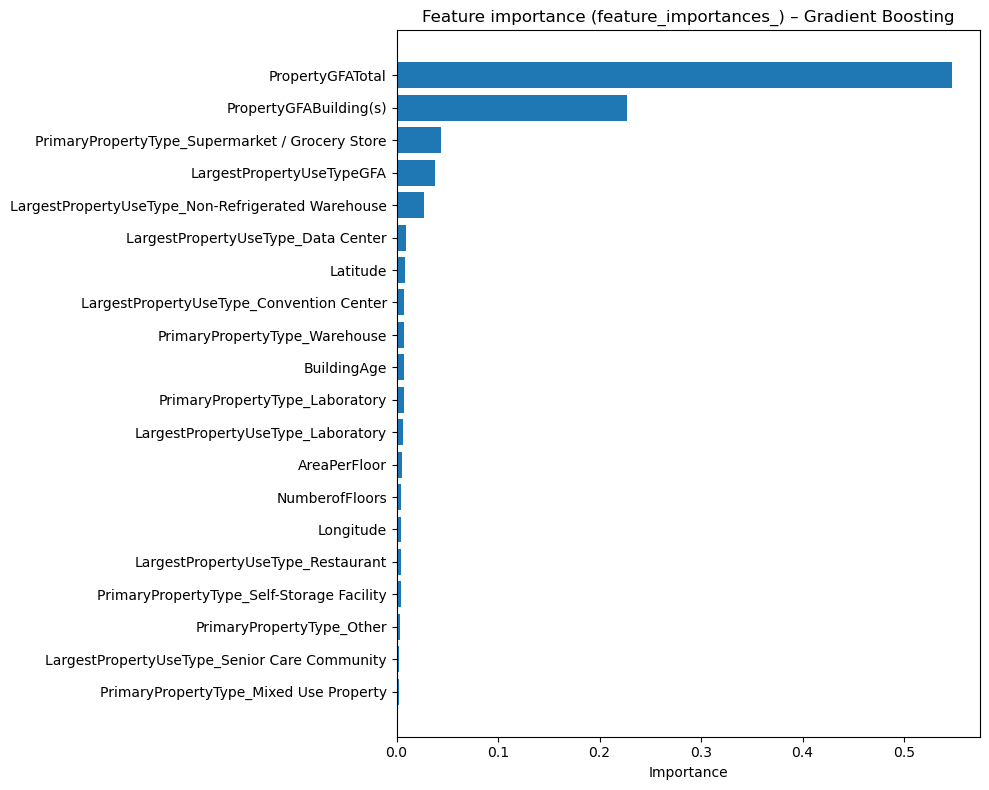

In [20]:
from sklearn.inspection import permutation_importance

best_gb = grid_gb.best_estimator_

# 1) Récupérer le modèle et le préprocesseur
prepro = best_gb.named_steps["prepro"]
gb_model = best_gb.named_steps["model"]

# 2) Récupérer les noms de features après prétraitement
#    a) colonnes numériques (restent telles quelles)
num_feature_names = num_cols  # ta liste num_cols définie plus haut

#    b) colonnes catégorielles → noms des colonnes OneHot
ohe = prepro.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

#    c) concaténer tout
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 3) Importances natives du modèle Gradient Boosting
importances = gb_model.feature_importances_

fi_gb = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# 4) Affichage
plt.figure(figsize=(10,8))
plt.barh(fi_gb["feature"].head(20), fi_gb["importance"].head(20))
plt.gca().invert_yaxis()
plt.title("Feature importance (feature_importances_) – Gradient Boosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [21]:
from pprint import pprint

print("Steps du pipeline :")
pprint(list(best_gb.named_steps.keys()))

print("\nTypes des steps :")
for name, step in best_gb.named_steps.items():
    print(f"- {name}: {type(step)}")

Steps du pipeline :
['prepro', 'model']

Types des steps :
- prepro: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
- model: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


# BENTOML

In [22]:
import sys, bentoml
print(sys.executable)
print(bentoml.__version__)
cat_cols

C:\Users\matde\anaconda3\python.exe
1.4.28


['PrimaryPropertyType',
 'LargestPropertyUseType',
 'Neighborhood',
 'GeoCluster',
 'CouncilDistrictCode']

In [23]:
import bentoml

# --- Sauvegarde BentoML du PIPELINE complet ---
feature_names = X_train.columns.tolist()

bento_model = bentoml.sklearn.save_model(
    "energy_consumption_model",
    best_gb,  # <--- le pipeline complet (prepro + lasso)
    custom_objects={"feature_names": feature_names},  # pas besoin de 'preprocessor'
)

print("Model tag:", bento_model.tag)

Model tag: energy_consumption_model:p4b35zoerkkccoen


In [24]:
df_fe.to_csv("C:\\Users\\matde\\Documents\\OpenClassrooms\\Projet_6\\df_model_bento.csv", index=False)

In [25]:
df_fe

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,NumberofBuildings,NumberofFloors,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,SiteEnergyUse(kBtu),HasParking,BuildingAge,ParkingRatio,AreaPerFloor,BuildingDensity,GeoCluster
0,88434.000,88434.00,0,1.0,12,Hotel,Hotel,88434.000,7,DOWNTOWN,47.61220,-122.33799,1927,7.226362e+06,0,89,0.000000,7369.500000,0.000011,2.0
1,103566.000,88502.00,15064,1.0,11,Hotel,Hotel,83880.000,7,DOWNTOWN,47.61317,-122.33393,1996,8.387933e+06,1,20,0.145453,8045.636364,0.000010,2.0
2,224864.625,196071.25,196718,1.0,41,Hotel,Hotel,192159.375,7,DOWNTOWN,47.61393,-122.33810,1969,1.633700e+07,1,47,0.874829,4782.225610,0.000004,2.0
3,61320.000,61320.00,0,1.0,10,Hotel,Hotel,61320.000,7,DOWNTOWN,47.61412,-122.33664,1926,6.794584e+06,0,90,0.000000,6132.000000,0.000016,2.0
4,175580.000,113580.00,62000,1.0,18,Hotel,Hotel,123445.000,7,DOWNTOWN,47.61375,-122.34047,1980,1.417261e+07,1,36,0.353115,6310.000000,0.000006,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,224864.625,196071.25,85028,1.0,6,Mixed Use Property,Laboratory,151523.000,7,LAKE UNION,47.62497,-122.33883,2015,1.633700e+07,1,1,0.378130,32678.541667,0.000004,0.0
1534,68072.000,68072.00,0,1.0,1,University,College/University,68916.000,4,NORTHEAST,47.66127,-122.31256,1962,3.180819e+06,0,54,0.000000,68072.000000,0.000015,9.0
1535,20616.000,20616.00,0,1.0,1,Mixed Use Property,Other - Recreation,9900.000,5,NORTH,47.70541,-122.32232,2005,6.369655e+05,0,11,0.000000,20616.000000,0.000049,4.0
1536,23445.000,23445.00,0,1.0,1,Other,Other - Recreation,23445.000,3,EAST,47.63228,-122.31574,1912,5.976246e+06,0,104,0.000000,23445.000000,0.000043,2.0


In [26]:
y_train_pred = best_gb.predict(X_train)
y_test_pred = best_gb.predict(X_test)

print("Train preds min / max :", y_train_pred.min(), y_train_pred.max())
print("Test  preds min / max :", y_test_pred.min(),  y_test_pred.max())
print("y min / max :", y.min(), y.max())


Train preds min / max : 129650.93864089003 16767723.779175863
Test  preds min / max : 333238.28594393 21625258.890590508
y min / max : 0.0 16336999.203125
